In [1]:
from unsloth import FastModel
import torch
import torch.nn as nn
from datasets import load_dataset
import re
from trl import GRPOConfig, GRPOTrainer
from transformers import (
    GPT2Model,
    GPT2Tokenizer,
    GPT2PreTrainedModel,
    GPT2Config,
    Trainer,
    TrainingArguments,
    AutoModelForCausalLM,
    TextStreamer
)
from typing import Dict, List
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from datasets import Dataset as HFDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
import time
from sklearn.preprocessing import StandardScaler
import pickle

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-29 22:26:40 [__init__.py:256] Automatically detected platform cuda.


In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# --- Configuration ---
pess = False
GPT2_MODEL_NAME = "gpt2"
FFN_MODEL_PATH = 'reward_predictor_model.pth'  # Path to your trained FFN model
SCALER_PATH = 'reward_predictor_scaler.pkl'   # Path to your saved scaler
if pess: 
    FFN_MODEL_PATH = 'reward_predictor_model_p.pth'  # Path to your trained FFN model
    SCALER_PATH = 'reward_predictor_scaler_p.pkl'   # Path to your saved scaler
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 512 # Max length for tokenizer, should match training

In [4]:
# --- Neural Network Definition (from your notebook) ---
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1, dropout_rate=0.2):
        super(FeedForwardNet, self).__init__()
        
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Additional hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# --- Embedding Extraction Function (from your notebook) ---
def extract_embedding(text, model, tokenizer, device, max_length=MAX_LENGTH):
    """
    Extract the embedding from GPT-2 for a given text.
    This version uses the embedding of the last token.
    """
    encoded_input = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        outputs = model(**encoded_input)
        last_hidden_state = outputs.last_hidden_state
        
        # Get the last token's embedding (considering padding)
        # The attention mask is 1 for non-pad tokens and 0 for pad tokens.
        # Summing the attention mask gives the sequence length of non-pad tokens.
        last_token_idx = encoded_input['attention_mask'].sum(dim=1) - 1
        
        # Gather the embedding of the last non-pad token for each item in the batch
        # last_token_idx needs to be reshaped for torch.gather
        # Shape: (batch_size, 1, hidden_size) to match last_hidden_state (batch_size, seq_len, hidden_size)
        last_token_idx_expanded = last_token_idx.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, last_hidden_state.size(-1))
        
        # (batch_size, 1, hidden_size)
        last_token_embedding = torch.gather(last_hidden_state, 1, last_token_idx_expanded).squeeze(1)
        
        return last_token_embedding.cpu().numpy().flatten()

class GPT2RewardModel:
    def __init__(self, gpt2_model_name, ffn_model_path, scaler_path, device):
        self.device = device
        
        # 1. Load GPT-2 Model and Tokenizer
        print(f"Loading GPT-2 model: {gpt2_model_name}...")
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        self.gpt2_model = GPT2Model.from_pretrained(gpt2_model_name)
        self.gpt2_model.to(self.device)
        self.gpt2_model.eval()  # Set to evaluation mode
        # Freeze GPT-2 parameters
        for param in self.gpt2_model.parameters():
            param.requires_grad = False
        print("GPT-2 model loaded and frozen.")

        # 2. Load Scaler
        print(f"Loading scaler from: {scaler_path}...")
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        print("Scaler loaded.")

        # 3. Load Trained FeedForwardNet
        print(f"Loading FFN model from: {ffn_model_path}...")
        checkpoint = torch.load(ffn_model_path, map_location=self.device)
        
        # Ensure all necessary keys are present in the checkpoint
        required_keys = ['input_size', 'hidden_sizes', 'output_size', 'dropout_rate', 'model_state_dict']
        for key in required_keys:
            if key not in checkpoint:
                raise KeyError(f"Checkpoint missing required key: '{key}'. Ensure your saved model .pth file contains all necessary architecture parameters.")

        self.ffn_model = FeedForwardNet(
            input_size=checkpoint['input_size'],
            hidden_sizes=checkpoint['hidden_sizes'],
            output_size=checkpoint['output_size'],
            dropout_rate=checkpoint['dropout_rate']
        )
        self.ffn_model.load_state_dict(checkpoint['model_state_dict'])
        self.ffn_model.to(self.device)
        self.ffn_model.eval() # Set to evaluation mode
        print("FFN model loaded.")

    def get_rewards(self, questions, answers):
        """
        Computes the reward for a given question-answer pair.
        """
        rewards = []
        for question, answer in zip(questions, answers):
            text = f"Question: {question} Answer: {answer}"
            
            # a. Get GPT-2 embedding
            embedding = extract_embedding(text, self.gpt2_model, self.tokenizer, self.device)
            
            # b. Scale the embedding
            # Scaler expects a 2D array, so reshape if it's 1D
            if embedding.ndim == 1:
                embedding_reshaped = embedding.reshape(1, -1)
            else:
                embedding_reshaped = embedding
            
            scaled_embedding = self.scaler.transform(embedding_reshaped)
            
            # c. Pass to FFN
            scaled_embedding_tensor = torch.tensor(scaled_embedding, dtype=torch.float32).to(self.device)
            
            with torch.no_grad():
                reward = self.ffn_model(scaled_embedding_tensor)
            rewards.append(reward.item())
        return rewards
        text = f"Question: {question} Answer: {answer}"
            
        # # a. Get GPT-2 embedding
        # embedding = extract_embedding(text, self.gpt2_model, self.tokenizer, self.device)
        
        # # b. Scale the embedding
        # # Scaler expects a 2D array, so reshape if it's 1D
        # if embedding.ndim == 1:
        #     embedding_reshaped = embedding.reshape(1, -1)
        # else:
        #     embedding_reshaped = embedding
        
        # scaled_embedding = self.scaler.transform(embedding_reshaped)
        
        # # c. Pass to FFN
        # scaled_embedding_tensor = torch.tensor(scaled_embedding, dtype=torch.float32).to(self.device)
        
        # with torch.no_grad():
        #     reward = self.ffn_model(scaled_embedding_tensor)
        # return reward.item()



# Non list implementation
class RewardFunction:
    def __init__(self, model, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model = model
        self.device = device
        print(f"Reward function initialized on device: {device}")
    
    def __call__(self, query_text: str, response_text: str) -> torch.Tensor:
        """
        Calculate rewards for each query-response pair
        
        Args:
            query_text: List of query/instruction strings
            response_text: List of response strings
            
        Returns:
            torch.Tensor of rewards
        """
        return self.model.get_rewards(query_text, response_text)





In [5]:
d = load_dataset("Columbia-NLP/DPO-tldr-summarisation-preferences")
train = d['train']
val = d['validation']
test = d['test']
dataset = train.add_column("sub_reddit", [x['subreddit'] for x in train['other_info']])
dataset_test = val.add_column("sub_reddit", [x['subreddit'] for x in val['other_info']])
dataset_eval = test.add_column("sub_reddit", [x['subreddit'] for x in test['other_info']])

In [6]:
reward_model = GPT2RewardModel(
    gpt2_model_name=GPT2_MODEL_NAME,
    ffn_model_path=FFN_MODEL_PATH,
    scaler_path=SCALER_PATH,
    device=DEVICE
)

# Initialize the reward function
reward_fn = RewardFunction(reward_model)


Loading GPT-2 model: gpt2...
GPT-2 model loaded and frozen.
Loading scaler from: reward_predictor_scaler.pkl...
Scaler loaded.
Loading FFN model from: reward_predictor_model.pth...
FFN model loaded.
Reward function initialized on device: cuda


Test rewards: [3.291637659072876, 3.1862475872039795]


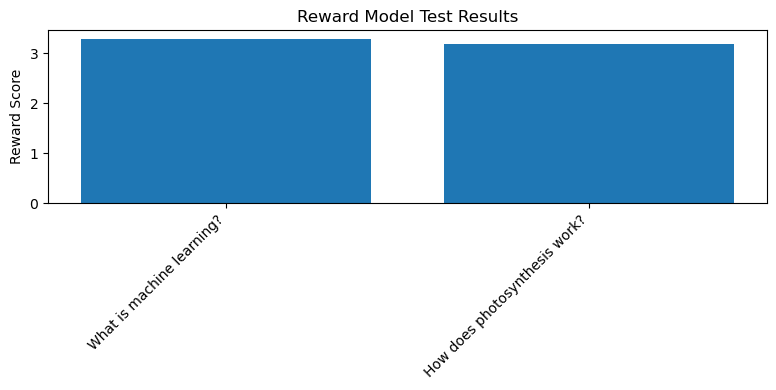

In [7]:
# Test the reward function with some example data
test_queries = [
    "What is machine learning?",
    "How does photosynthesis work?"
]

test_responses = [
    "Machine learning is a field of artificial intelligence that enables computers to learn from data without being explicitly programmed.",
    "Photosynthesis is the process where plants convert sunlight, water, and carbon dioxide into oxygen and glucose for energy."
]

# Get rewards for test data
rewards = reward_fn(test_queries, test_responses)
print("Test rewards:", rewards)

# Visualize the rewards
plt.figure(figsize=(8, 4))
plt.bar(range(len(test_queries)), rewards)
plt.xticks(range(len(test_queries)), test_queries, rotation=45, ha='right')
plt.ylabel('Reward Score')
plt.title('Reward Model Test Results')
plt.tight_layout()
plt.show()

In [8]:
# Format Dataset for GRPO Trainer
rem_col = dataset.column_names
rem_col.remove('prompt')
dataset_rew = dataset.remove_columns(rem_col)

In [9]:
# Create reward function that passes the prompt and answer to our finetuned GPT2 to predict the glicko score - volatility
def gpt_reward(prompts, completions, **kwargs):
    return reward_fn(prompts, completions)
        

In [10]:
max_seq_length = 512

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-1b-it",
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

==((====))==  Unsloth 2025.4.7: Fast Gemma3 patching. Transformers: 4.51.3. vLLM: 0.8.1.
   \\   /|    NVIDIA GeForce RTX 3060. Num GPUs = 1. Max memory: 11.999 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


In [11]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [12]:
# Ensure proper padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
print(tokenizer.padding_side)
max_prompt_length = 480
max_seq_length = 512
# Configure GRPO - adjust based on your GPU memory
training_args = GRPOConfig(
    learning_rate = 2e-4,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_torch_fused",
    logging_steps = 1,
    per_device_train_batch_size = 12,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    num_train_epochs = 4, # Set to 1 for a full training run
    max_steps = 100,
    save_steps = 50,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

left


In [13]:
trainer = GRPOTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=dataset_rew,
        reward_funcs=gpt_reward  # This is the correct place for the reward_model parameter
    )

In [14]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 92,858 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 12 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (12 x 4 x 1) = 48
 "-____-"     Trainable parameters = 6,522,880/1,006,408,832 (0.65% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 32768, 'top_k': 64, 'top_p': 0.95, 'bos_token_id': 2, 'eos_token_id': [1, 106]}. If this is not desired, please set these values explicitly.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / gpt_reward
1,0.000000,2.584647,0.759794,32.000000,0.000000,2.584647
2,0.000000,2.756225,0.680291,32.000000,0.000000,2.756225
3,0.000100,2.586611,0.827773,32.000000,0.001757,2.586611
4,0.000100,2.708111,0.801176,32.000000,0.002184,2.708111
5,0.000400,2.739838,0.745014,32.000000,0.010009,2.739838
6,0.000300,2.598768,0.887447,32.000000,0.007290,2.598768
7,0.000300,2.643855,0.711153,32.000000,0.007095,2.643855
8,0.001000,2.516932,0.731134,32.000000,0.024930,2.516932
9,0.001000,2.599454,0.949716,32.000000,0.023935,2.599454
10,0.001500,2.984378,1.012502,32.000000,0.037102,2.984378


TrainOutput(global_step=100, training_loss=0.00505745602798319, metrics={'train_runtime': 1976.8254, 'train_samples_per_second': 2.428, 'train_steps_per_second': 0.051, 'total_flos': 0.0, 'train_loss': 0.00505745602798319})

In [15]:
# Save the model to a local directory
output_path = "gemma_glicko_base"
if pess:
    output_path = 'gemma_glicko_pess'
trainer.save_model(output_path)
print(f"Model saved to {output_path}")

Model saved to gemma_glicko_base


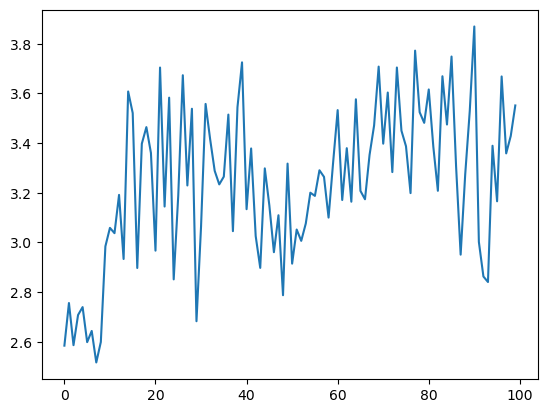

In [16]:
logs = trainer.state.log_history
rewards = [log.get('reward', 0) for log in logs if 'reward' in log]
plt.plot(rewards)